# **Part 1: Carbon intensity differences between sectors**

This part of the report on carbon intensity aims to answer the following questions:
- Are there significant differences in average carbon intensity (CI) among sectors?
- Which sectors differ significantly in their average CI?
- Are there any sectors with overlapping CI ranges that make it difficult to distinguish their environmental performance?
- What could be reasons of these differences if any?

---
*Collapse the following heading to get straight to the **Summary for policy makers***

# Detailed analysis for data analysts

Data source: https://springernature.figshare.com/collections/The_Carbon_Catalogue_Carbon_footprints_of_866_commercial_products_from_8_industry_sectors_and_5_continents/5408100  
Context and description of the data: https://www.nature.com/articles/s41597-022-01178-9 

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
# import data
path = "PublicTablesForCarbonCatalogueDataDescriptor_v30Oct2021.xlsx"
df = pd.read_excel(path)

## Inspect the data

In an initial inspection, we first check if we need to clean the data.

In [3]:
# check if data loaded correctly
df.head()

,*PCF-ID,Year of reporting,*Stage-level CO2e available,Product name (and functional unit),Product detail,Company,Country (where company is incorporated),Company's GICS Industry Group,Company's GICS Industry,*Company's sector,...,Relative change in PCF vs previous,Company-reported reason for change,*Change reason category,*%Upstream estimated from %Operations,*Upstream CO2e (fraction of total PCF),*Operations CO2e (fraction of total PCF),*Downstream CO2e (fraction of total PCF),*Transport CO2e (fraction of total PCF),*EndOfLife CO2e (fraction of total PCF),*Adjustments to raw data (if any)
0,10056-1-2014,2014,Yes,Frosted Flakes(R) Cereal,"Frosted Flakes(R), 23 oz., Produced in Lancast...",Kellogg Company,USA,"Food, Beverage & Tobacco",Food Products,Food & Beverage,...,(not reported by company),N/a,N/a (no %change reported),No,0.575,0.3,0.125,0.045,(included in downstream but not reported separ...,Divided stage and total emissions by 1000 (bas...
1,10056-1-2015,2015,Yes,"Frosted Flakes, 23 oz, produced in Lancaster, ...",Cereal,Kellogg Company,USA,Food & Beverage Processing,Not used for 2015 reporting,Food & Beverage,...,(not reported by company),N/a,N/a (no %change reported),No,0.575,0.3,0.125,0.045,(included in downstream but not reported separ...,Divided stage and total emissions by 1000 (bas...
2,10222-1-2013,2013,Yes,Office Chair,Field not included in 2013 data,KNOLL INC,USA,Capital Goods,Building Products,Comm. equipm. & capital goods,...,(not reported by company),N/a,N/a (no previous data available),Yes,0.8063,0.1736,0.0201,(included in up/downstream but not reported se...,0,"Changed %change to zero, according to field ""c..."
3,10261-1-2017,2017,Yes,Multifunction Printers,bizhub C458,"Konica Minolta, Inc.",Japan,Technology Hardware & Equipment,"Electronic Equipment, Instruments & Components","Computer, IT & telecom",...,(not reported by company),N/a,N/a (no previous data available),No,0.3065,0.0551,0.6384,0.0101,0.0276,NaN
4,10261-2-2017,2017,Yes,Multifunction Printers,bizhub C558,"Konica Minolta, Inc.",Japan,Technology Hardware & Equipment,"Electronic Equipment, Instruments & Components","Computer, IT & telecom",...,(not reported by company),N/a,N/a (no previous data available),No,0.2508,0.0451,0.7041,0.0083,0.0226,NaN


In [4]:
# check data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866 entries, 0 to 865
Data columns (total 25 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   *PCF-ID                                    866 non-null    object 
 1   Year of reporting                          866 non-null    int64  
 2   *Stage-level CO2e available                866 non-null    object 
 3   Product name (and functional unit)         866 non-null    object 
 4   Product detail                             856 non-null    object 
 5   Company                                    866 non-null    object 
 6   Country (where company is incorporated)    866 non-null    object 
 7   Company's GICS Industry Group              866 non-null    object 
 8   Company's GICS Industry                    866 non-null    object 
 9   *Company's sector                          866 non-null    object 
 10  Product weight (kg)       

Company's sector and Carbon intensity have no missing values and are in the correct data format, no cleaning necessary.

## Check ANOVA assumptions

To answer the question if there are significant differences in carbon intensity among sectors, we can use an Analysis of Variance, but we first need to check the assumptions:
- independent samples: we assume that this holds
- similar sample size of groups 
- similar variance of groups 
- normal distribution of the dependent variable for each group 

To get a first overview, we take a look at mean carbon intensity and at boxplots of carbon intensity across sectors.

In [5]:
# calculate mean carbon intensity across sectors
sector_average = df.groupby('*Company\'s sector')['*Carbon intensity'].mean()
print(sector_average)

*Company's sector
Automobiles & components                 21.599867
Chemicals                                 5.173017
Comm. equipm. & capital goods           106.041607
Computer, IT & telecom                   75.294625
Construction & commercial materials       1.178955
Food & Beverage                           5.087266
Home durables, textiles, & equipment     13.283033
Packaging for consumer goods              1.276053
Name: *Carbon intensity, dtype: float64


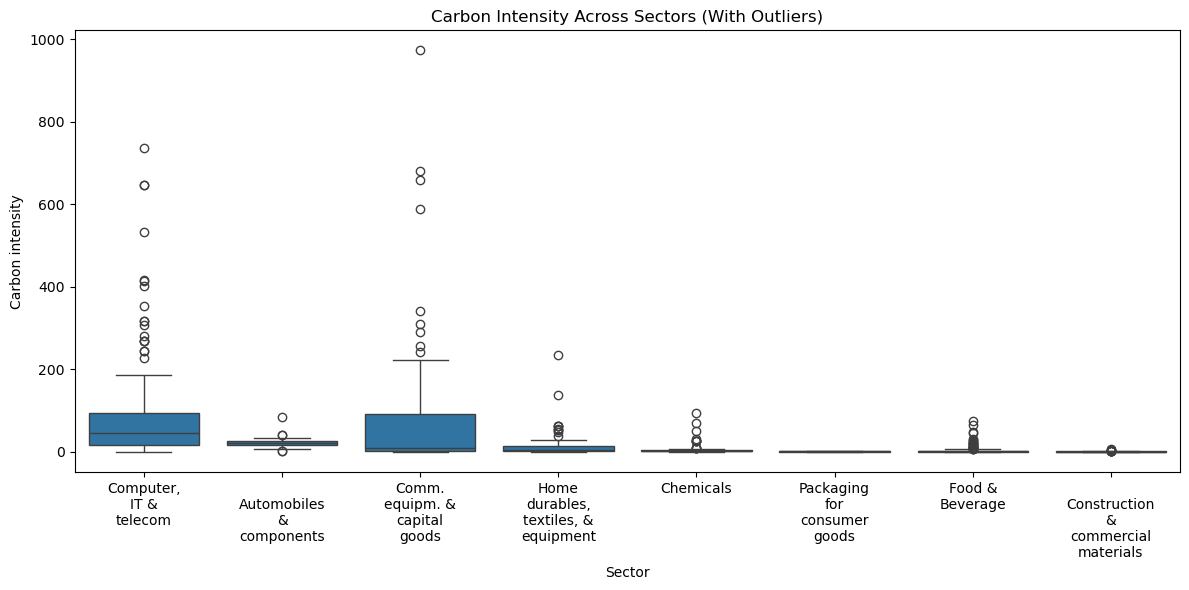

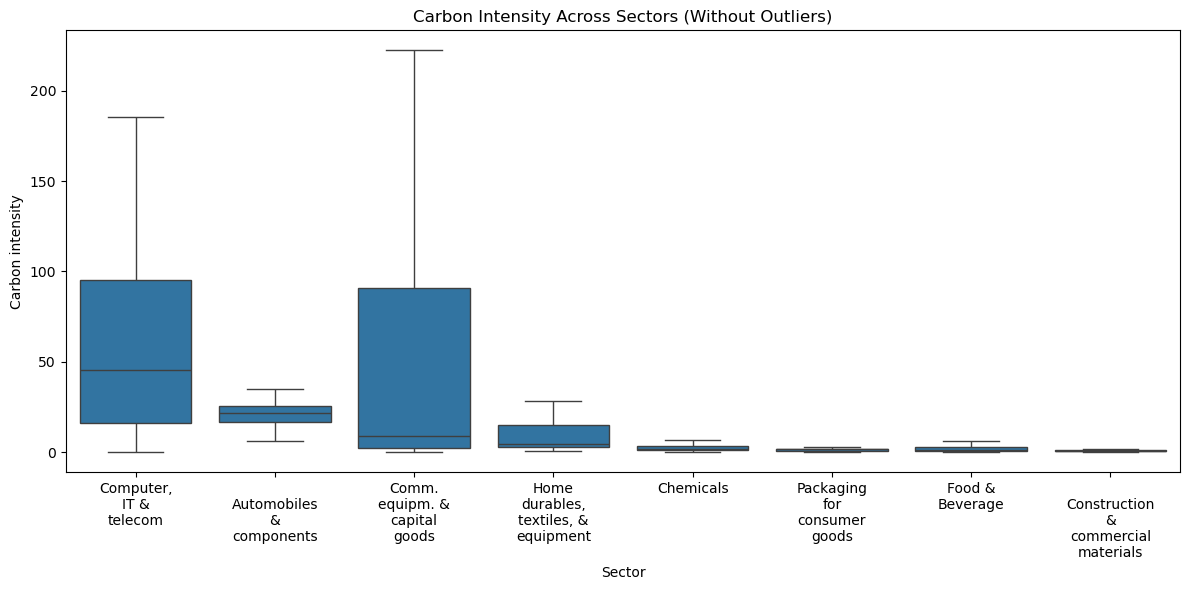

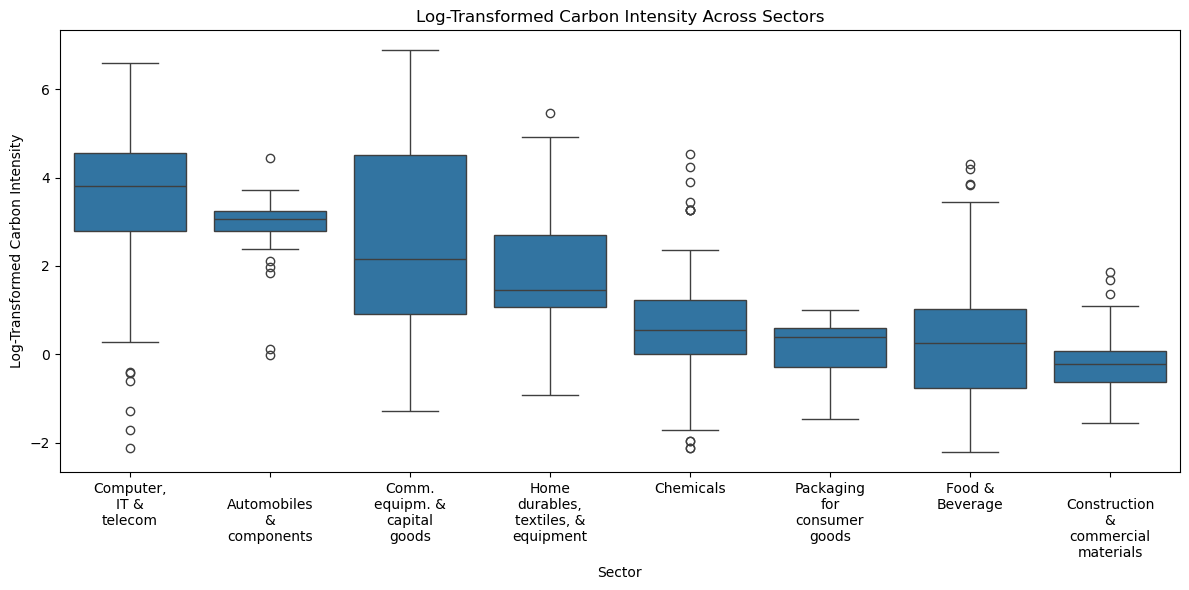

In [25]:
# Function to get ordered categories by median
def get_order_by_median(data, x, y):
    return data.groupby(x)[y].median().sort_values(ascending=False).index

# Function to wrap long labels
def wrap_labels(labels, max_len=11):
    wrapped_labels = []
    for label in labels:
        words = label.split()  # Split the label into words
        wrapped_line = []
        current_line = ""
        for word in words:
            if len(current_line) + len(word) + 1 <= max_len:
                current_line = f"{current_line} {word}".strip()
            else:
                wrapped_line.append(current_line)  # Start a new line
                current_line = word
        wrapped_line.append(current_line)  # Add the last line
        wrapped_labels.append("\n".join(wrapped_line))  # Join lines with a newline
    return wrapped_labels

#----------------------------------------------------------
# Plot distribution with outliers (non-log-transformed)
plt.figure(figsize=(12, 6))
order = get_order_by_median(df, "*Company's sector", "*Carbon intensity")
sns.boxplot(x='*Company\'s sector', y="*Carbon intensity", data=df, order=order)
plt.tight_layout()
plt.ylabel("Carbon intensity")
plt.xlabel("Sector")
plt.title("Carbon Intensity Across Sectors (With Outliers)")

# Wrap the x-axis labels
labels = plt.gca().get_xticklabels()
new_labels = wrap_labels([label.get_text() for label in labels])
plt.xticks(ticks=range(len(new_labels)), labels=new_labels, rotation=0)
plt.tight_layout()
plt.show()

#----------------------------------------------------------
# Plot distribution without outliers (non-log-transformed)
plt.figure(figsize=(12, 6))
sns.boxplot(x='*Company\'s sector', y="*Carbon intensity", data=df, showfliers=False, order=order)
plt.tight_layout()
plt.ylabel("Carbon intensity")
plt.xlabel("Sector")
plt.title("Carbon Intensity Across Sectors (Without Outliers)")

# Wrap the x-axis labels
labels = plt.gca().get_xticklabels()
new_labels = wrap_labels([label.get_text() for label in labels])
plt.xticks(ticks=range(len(new_labels)), labels=new_labels, rotation=0)
plt.tight_layout()
plt.show()

#----------------------------------------------------------
# Plot distribution for log-transformed data
plt.figure(figsize=(12, 6))
log_order = get_order_by_median(df, "*Company's sector", "log_Carbon_intensity")
sns.boxplot(x='*Company\'s sector', y="log_Carbon_intensity", data=df, order=log_order)
plt.tight_layout()
plt.ylabel("Log-Transformed Carbon Intensity")
plt.xlabel("Sector")
plt.title("Log-Transformed Carbon Intensity Across Sectors")

# Wrap the x-axis labels
labels = plt.gca().get_xticklabels()
new_labels = wrap_labels([label.get_text() for label in labels])
plt.xticks(ticks=range(len(new_labels)), labels=new_labels, rotation=0)
plt.tight_layout()
plt.show()


We can see that:
- there seem to be differences in mean carbon intensity between different sectors
- sectors differ in their variance
- carbon intensity within sectors is not normally distributed, but this gets better with log-transformation
- there are outliers

Now we can take a closer look at the assumptions.

In [7]:
# show sample sizes of sectors
df["*Company's sector"].value_counts()

*Company's sector
Computer, IT & telecom                  253
Food & Beverage                         139
Home durables, textiles, & equipment    122
Chemicals                               116
Automobiles & components                 75
Construction & commercial materials      67
Comm. equipm. & capital goods            56
Packaging for consumer goods             38
Name: count, dtype: int64

The sample sizes of the different groups, i.e. sectors, we want to compare differ a lot.

In [8]:
# calculate variance in carbon intensity across sectors
variance_by_sector = df.groupby('*Company\'s sector')['*Carbon intensity'].var()
print(variance_by_sector)

*Company's sector
Automobiles & components                  111.583872
Chemicals                                 155.532613
Comm. equipm. & capital goods           40017.344996
Computer, IT & telecom                  10898.021103
Construction & commercial materials         1.290703
Food & Beverage                           125.880768
Home durables, textiles, & equipment      732.011116
Packaging for consumer goods                0.453014
Name: *Carbon intensity, dtype: float64


In [9]:
# calculate standard deviation in carbon intensity across sectors
std_by_sector = df.groupby('*Company\'s sector')['*Carbon intensity'].std()
print(std_by_sector)

*Company's sector
Automobiles & components                 10.563327
Chemicals                                12.471271
Comm. equipm. & capital goods           200.043358
Computer, IT & telecom                  104.393587
Construction & commercial materials       1.136091
Food & Beverage                          11.219660
Home durables, textiles, & equipment     27.055704
Packaging for consumer goods              0.673063
Name: *Carbon intensity, dtype: float64


The variance / standard deviation also differs a lot between sectors.

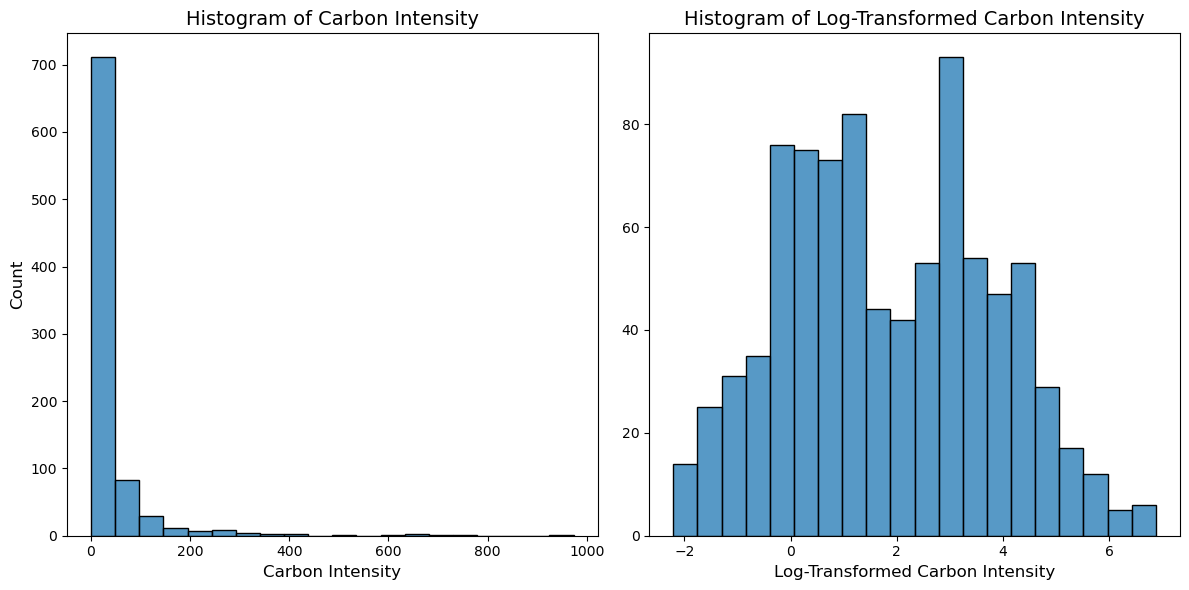

In [10]:
# Log-transform the Carbon intensity variable and store it in a new column
df['log_Carbon_intensity'] = np.log(df["*Carbon intensity"])

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

# First subplot: Non-log-transformed data
sns.histplot(x='*Carbon intensity', data=df, ax=axes[0], bins=20)
axes[0].set_title('Histogram of Carbon Intensity', fontsize=14)
axes[0].set_xlabel('Carbon Intensity', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)

# Second subplot: Log-transformed data
sns.histplot(x='log_Carbon_intensity', data=df, ax=axes[1], bins=20)
axes[1].set_title('Histogram of Log-Transformed Carbon Intensity', fontsize=14)
axes[1].set_xlabel('Log-Transformed Carbon Intensity', fontsize=12)
axes[1].set_ylabel('')  # Remove redundant y-axis label for clarity

# Adjust layout for spacing
plt.tight_layout()

# Display the plots
plt.show()

Carbon intensity is right-skewed. After a log-transformation it is more normally distributed than before, but shows a bimodal pattern.

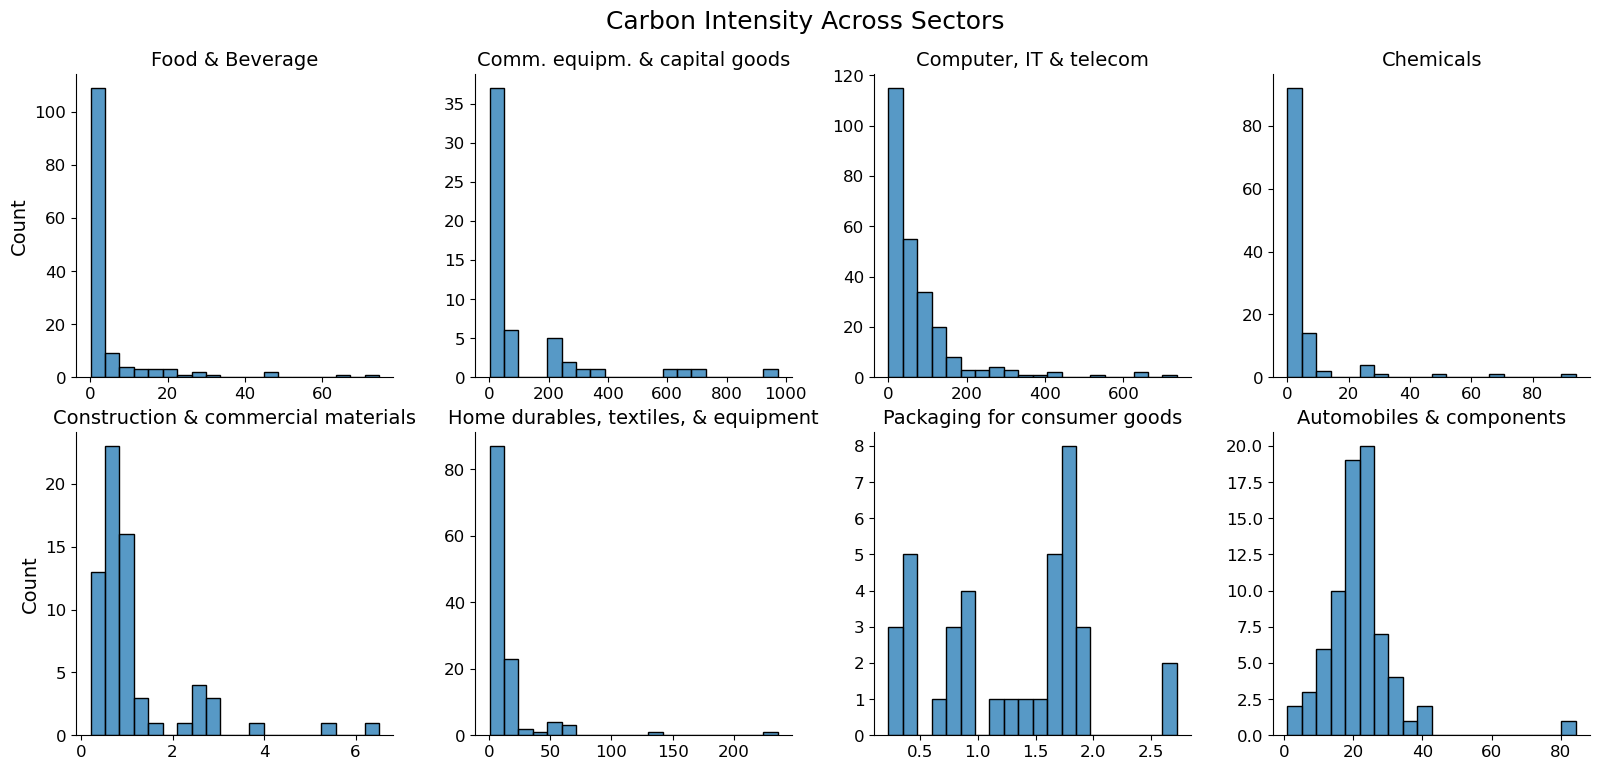

In [11]:
# Create a FacetGrid for the panel plot
g = sns.FacetGrid(df, col="*Company's sector", col_wrap=4, height=4, sharex=False, sharey=False)

# Map a histogram onto each facet
g.map(sns.histplot, "*Carbon intensity", bins=20, kde=False)

# Set titles and labels with larger font sizes
g.set_titles(col_template="{col_name}", size=14)  # Sector names
g.set_axis_labels("", "Count", fontsize=14)  # Axis labels
g.figure.subplots_adjust(top=0.9)  # Add spacing for the overall title

# Set an overall title for the panel plot
g.figure.suptitle("Carbon Intensity Across Sectors", fontsize=18)

# Increase tick label sizes
for ax in g.axes.flat:
    ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust tick label size

# Show the plot
plt.show()

The carbon intensity is not normally distributed, but rather right-skewed for most sectors.

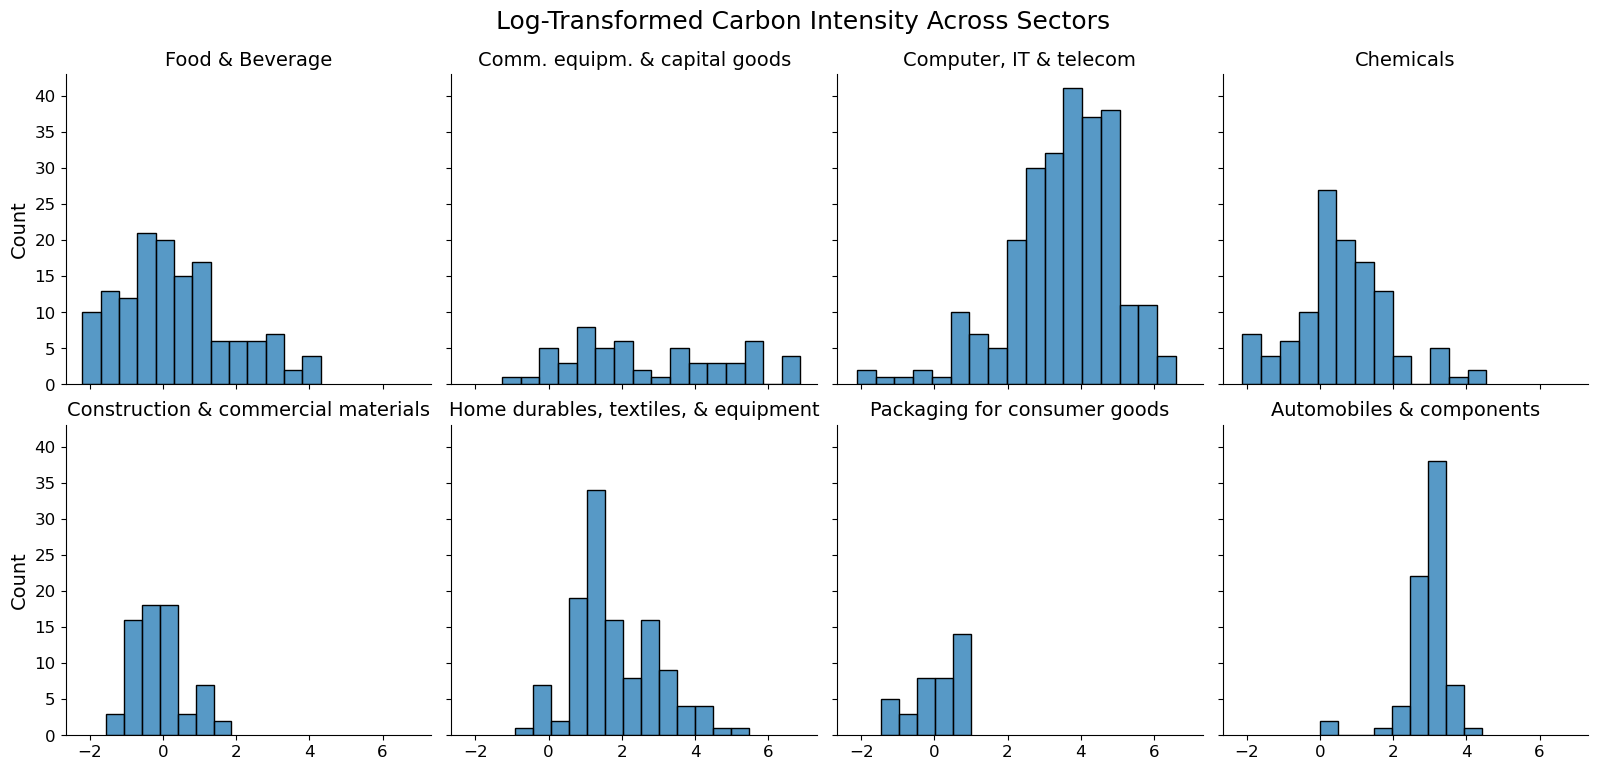

In [12]:
# Create a FacetGrid for the panel plot
g = sns.FacetGrid(df, col="*Company's sector", col_wrap=4, height=4, sharex=True, sharey=True)

# Map a histogram onto each facet
g.map(sns.histplot, "log_Carbon_intensity", binwidth=0.5, kde=False)

# Set titles and labels with larger font sizes
g.set_titles(col_template="{col_name}", size=14)  # Sector names
g.set_axis_labels("", "Count", fontsize=14)  # Axis labels
g.figure.subplots_adjust(top=0.9)  # Add spacing for the overall title

# Set an overall title for the panel plot
g.figure.suptitle("Log-Transformed Carbon Intensity Across Sectors", fontsize=18)

# Increase tick label sizes
for ax in g.axes.flat:
    ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust tick label size

# Show the plot
plt.show()

If we log-transform the carbon intensity, it is more normally distributed for most sectors.

To summarize, most of the ANOVA assumptions are not met:
- independent samples: we assume that this holds
- similar sample size of groups: not met
- similar variance of groups: not met
- normal distribution of the dependent variable for each group: after log-transformation only for some groups

## Data selection to meet ANOVA assumptions

In order to better meet the ANOVA assumptions, we focus on sectors with a sample size over 100.

In [13]:
# Calculate the counts for each sector
sector_counts = df["*Company's sector"].value_counts()

# Filter rows where the count of the sector is more than 100
df_selected = df[df["*Company's sector"].isin(sector_counts[sector_counts > 100].index)]

# Display the first few rows of the filtered DataFrame
df_selected.head()

,*PCF-ID,Year of reporting,*Stage-level CO2e available,Product name (and functional unit),Product detail,Company,Country (where company is incorporated),Company's GICS Industry Group,Company's GICS Industry,*Company's sector,...,Company-reported reason for change,*Change reason category,*%Upstream estimated from %Operations,*Upstream CO2e (fraction of total PCF),*Operations CO2e (fraction of total PCF),*Downstream CO2e (fraction of total PCF),*Transport CO2e (fraction of total PCF),*EndOfLife CO2e (fraction of total PCF),*Adjustments to raw data (if any),log_Carbon_intensity
0,10056-1-2014,2014,Yes,Frosted Flakes(R) Cereal,"Frosted Flakes(R), 23 oz., Produced in Lancast...",Kellogg Company,USA,"Food, Beverage & Tobacco",Food Products,Food & Beverage,...,N/a,N/a (no %change reported),No,0.575,0.3,0.125,0.045,(included in downstream but not reported separ...,Divided stage and total emissions by 1000 (bas...,0.982078
1,10056-1-2015,2015,Yes,"Frosted Flakes, 23 oz, produced in Lancaster, ...",Cereal,Kellogg Company,USA,Food & Beverage Processing,Not used for 2015 reporting,Food & Beverage,...,N/a,N/a (no %change reported),No,0.575,0.3,0.125,0.045,(included in downstream but not reported separ...,Divided stage and total emissions by 1000 (bas...,0.982078
3,10261-1-2017,2017,Yes,Multifunction Printers,bizhub C458,"Konica Minolta, Inc.",Japan,Technology Hardware & Equipment,"Electronic Equipment, Instruments & Components","Computer, IT & telecom",...,N/a,N/a (no previous data available),No,0.3065,0.0551,0.6384,0.0101,0.0276,NaN,2.604909
4,10261-2-2017,2017,Yes,Multifunction Printers,bizhub C558,"Konica Minolta, Inc.",Japan,Technology Hardware & Equipment,"Electronic Equipment, Instruments & Components","Computer, IT & telecom",...,N/a,N/a (no previous data available),No,0.2508,0.0451,0.7041,0.0083,0.0226,NaN,2.805177
5,10261-3-2017,2017,Yes,Multifunction Printers,bizhub C658,"Konica Minolta, Inc.",Japan,Technology Hardware & Equipment,"Electronic Equipment, Instruments & Components","Computer, IT & telecom",...,N/a,N/a (no previous data available),No,0.2005,0.0361,0.7634,0.0066,0.018,NaN,3.028683


In [14]:
# show selected sectors and sample size
df_selected["*Company's sector"].value_counts()

*Company's sector
Computer, IT & telecom                  253
Food & Beverage                         139
Home durables, textiles, & equipment    122
Chemicals                               116
Name: count, dtype: int64

The sample sizes of selected sectors are sufficiently similar.

In [15]:
# calculate standard deviation in carbon intensity across sectors
std_by_sector = df_selected.groupby('*Company\'s sector')['*Carbon intensity'].std()
print(std_by_sector)

*Company's sector
Chemicals                                12.471271
Computer, IT & telecom                  104.393587
Food & Beverage                          11.219660
Home durables, textiles, & equipment     27.055704
Name: *Carbon intensity, dtype: float64


The variance of selected sectors is also similar, except for the variance of "Computer, IT & telecom".

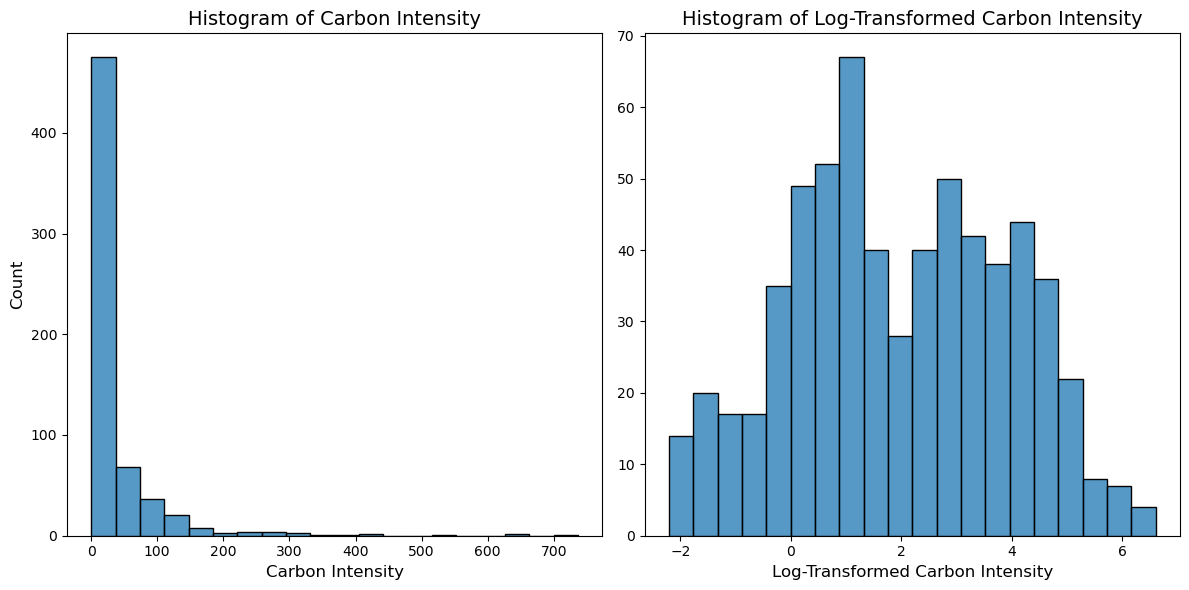

In [16]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

# First subplot: Non-log-transformed data
sns.histplot(x='*Carbon intensity', data=df_selected, ax=axes[0], bins=20)
axes[0].set_title('Histogram of Carbon Intensity', fontsize=14)
axes[0].set_xlabel('Carbon Intensity', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)

# Second subplot: Log-transformed data
sns.histplot(x='log_Carbon_intensity', data=df_selected, ax=axes[1], bins=20)
axes[1].set_title('Histogram of Log-Transformed Carbon Intensity', fontsize=14)
axes[1].set_xlabel('Log-Transformed Carbon Intensity', fontsize=12)
axes[1].set_ylabel('')  # Remove redundant y-axis label for clarity

# Adjust layout for spacing
plt.tight_layout()

# Display the plots
plt.show()

The overall distribution of carbon intensity for the selected data remain similar as before.

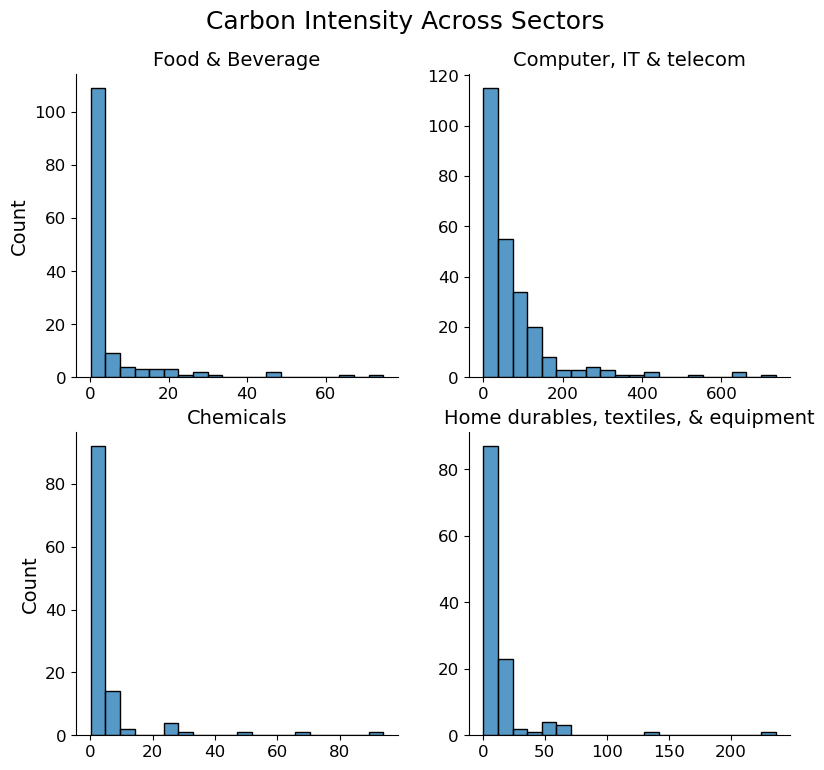

In [17]:
# Create a FacetGrid for the panel plot
g = sns.FacetGrid(df_selected, col="*Company's sector", col_wrap=2, height=4, sharex=False, sharey=False)

# Map a histogram onto each facet
g.map(sns.histplot, "*Carbon intensity", bins=20, kde=False)

# Set titles and labels with larger font sizes
g.set_titles(col_template="{col_name}", size=14)  # Sector names
g.set_axis_labels("", "Count", fontsize=14)  # Axis labels
g.figure.subplots_adjust(top=0.9)  # Add spacing for the overall title

# Set an overall title for the panel plot
g.figure.suptitle("Carbon Intensity Across Sectors", fontsize=18)

# Increase tick label sizes
for ax in g.axes.flat:
    ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust tick label size

# Show the plot
plt.show()

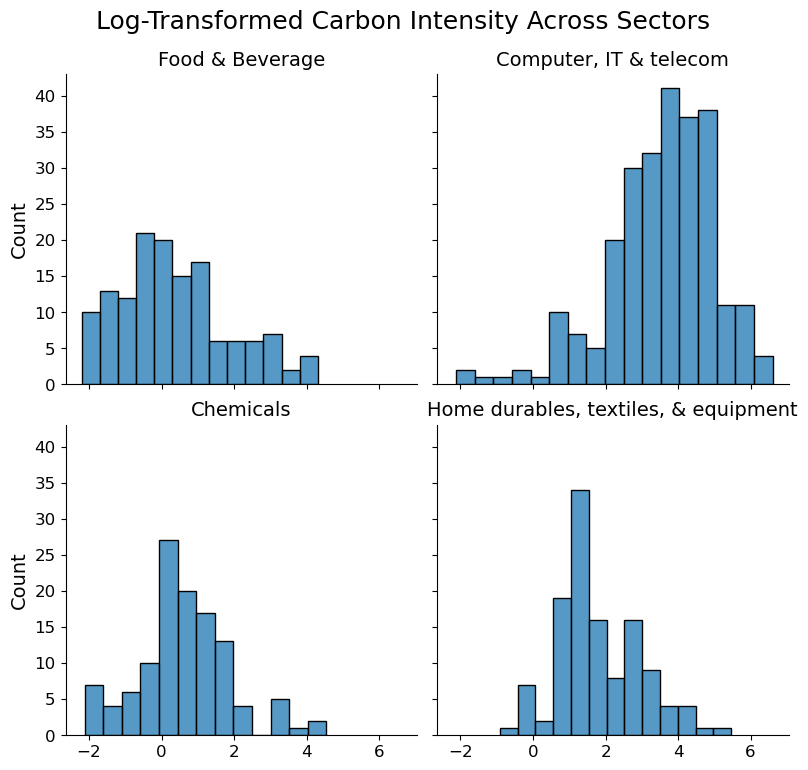

In [18]:
# Create a FacetGrid for the panel plot
g = sns.FacetGrid(df_selected, col="*Company's sector", col_wrap=2, height=4, sharex=True, sharey=True)

# Map a histogram onto each facet
g.map(sns.histplot, "log_Carbon_intensity", binwidth=0.5, kde=False)

# Set titles and labels with larger font sizes
g.set_titles(col_template="{col_name}", size=14)  # Sector names
g.set_axis_labels("", "Count", fontsize=14)  # Axis labels
g.figure.subplots_adjust(top=0.9)  # Add spacing for the overall title

# Set an overall title for the panel plot
g.figure.suptitle("Log-Transformed Carbon Intensity Across Sectors", fontsize=18)

# Increase tick label sizes
for ax in g.axes.flat:
    ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust tick label size

# Show the plot
plt.show()

Carbon intensity is approximately normally distributed for the selected sectors if we are very generous.

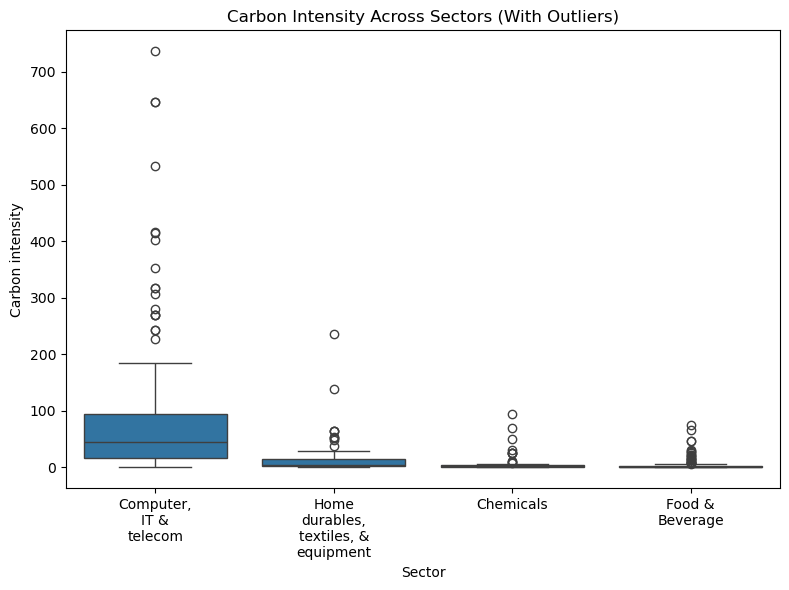

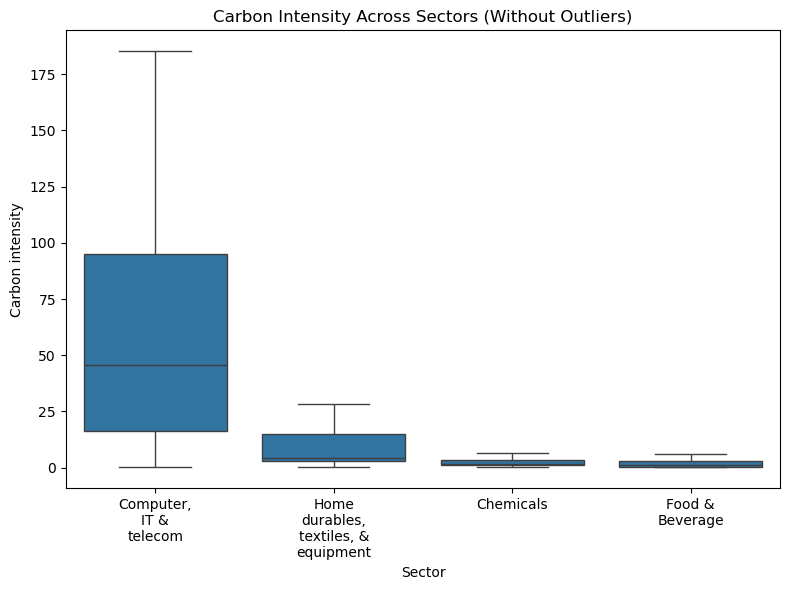

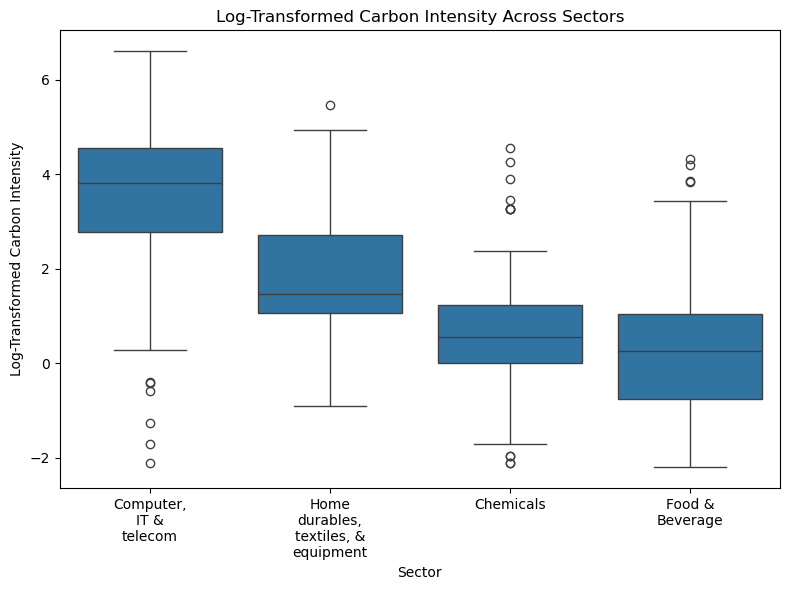

In [19]:
# Function to get ordered categories by median
def get_order_by_median(data, x, y):
    return data.groupby(x)[y].median().sort_values(ascending=False).index

# Plot distribution with outliers (non-log-transformed)
plt.figure(figsize=(8, 6))
order = get_order_by_median(df_selected, "*Company's sector", "*Carbon intensity")
sns.boxplot(x='*Company\'s sector', y="*Carbon intensity", data=df_selected, order=order)
plt.tight_layout()
plt.ylabel("Carbon intensity")
plt.xlabel("Sector")
plt.title("Carbon Intensity Across Sectors (With Outliers)")

# Function to wrap long labels
def wrap_labels(labels, max_len=11):
    wrapped_labels = []
    for label in labels:
        words = label.split()  # Split the label into words
        wrapped_line = []
        current_line = ""
        for word in words:
            if len(current_line) + len(word) + 1 <= max_len:
                current_line = f"{current_line} {word}".strip()
            else:
                wrapped_line.append(current_line)  # Start a new line
                current_line = word
        wrapped_line.append(current_line)  # Add the last line
        wrapped_labels.append("\n".join(wrapped_line))  # Join lines with a newline
    return wrapped_labels

labels = plt.gca().get_xticklabels()
new_labels = wrap_labels([label.get_text() for label in labels])
plt.xticks(ticks=range(len(new_labels)), labels=new_labels, rotation=0)
plt.tight_layout()
plt.show()

#----------------------------------------------------------
# Plot distribution without outliers (non-log-transformed)
plt.figure(figsize=(8, 6))
sns.boxplot(x='*Company\'s sector', y="*Carbon intensity", data=df_selected, showfliers=False, order=order)
plt.tight_layout()
plt.ylabel("Carbon intensity")
plt.xlabel("Sector")
plt.title("Carbon Intensity Across Sectors (Without Outliers)")

labels = plt.gca().get_xticklabels()
new_labels = wrap_labels([label.get_text() for label in labels])
plt.xticks(ticks=range(len(new_labels)), labels=new_labels, rotation=0)
plt.tight_layout()
plt.show()

#----------------------------------------------------------
# Plot distribution for log-transformed data
plt.figure(figsize=(8, 6))
log_order = get_order_by_median(df_selected, "*Company's sector", "log_Carbon_intensity")
sns.boxplot(x='*Company\'s sector', y="log_Carbon_intensity", data=df_selected, order=log_order)
plt.tight_layout()
plt.ylabel("Log-Transformed Carbon Intensity")
plt.xlabel("Sector")
plt.title("Log-Transformed Carbon Intensity Across Sectors")

labels = plt.gca().get_xticklabels()
new_labels = wrap_labels([label.get_text() for label in labels])
plt.xticks(ticks=range(len(new_labels)), labels=new_labels, rotation=0)
plt.tight_layout()
plt.show()


To summarize, most of the ANOVA assumptions are approximately met for the selected sectors:
- independent samples: we assume that this holds
- similar sample size of groups: yes
- similar variance of groups: is met for all, except "Computer, IT & telecom"
- normal distribution of the dependent variable for each group: after log-transformation approximately yes

Furthermore, when looking at the boxplots, we can already see that we would except a difference between all sectors, except for "Food & Beverage" compared to "Chemicals".

## ANOVA

We run an ANOVA to test the null hypothesis that the mean carbon intensity is the same for all 4 selected sectors.

In [21]:
# rename sector column
df_selected.rename(columns={"*Company's sector":"company_sector"}, inplace=True)

/var/folders/v8/1_2rlmrd0wl5w5t5n60h8s440000gn/T/ipykernel_1618/1769530782.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.rename(columns={"*Company's sector":"company_sector"}, inplace=True)


In [22]:
# run one-way anova that explains log carbon intensity by sector
formula = "log_Carbon_intensity ~ C(company_sector)"
model = ols(formula, data=df_selected).fit()
aov_table = anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(company_sector),1200.266591,3.0,205.317427,1.052202e-92
Residual,1219.845936,626.0,NaN,NaN


There is a significant difference in mean carbon intensity between the different sectors, so we can reject the null hypothesis.

Inspect the model:

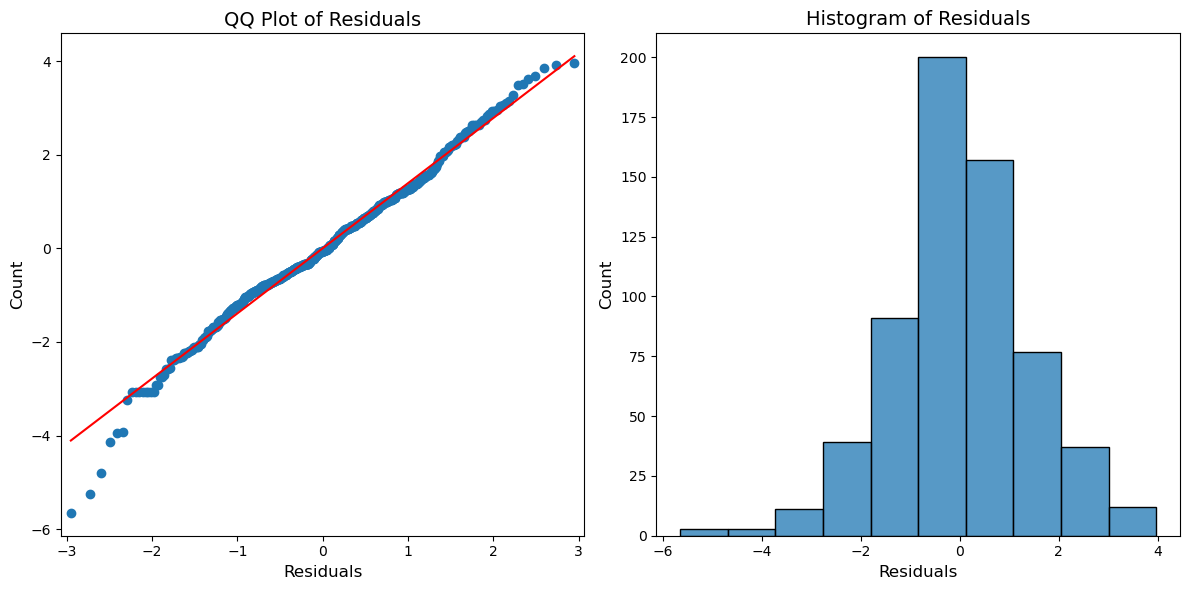

In [23]:
# Residuals from the model
res = model.resid 

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# QQ Plot
sm.qqplot(res, line='s', ax=axes[0])
axes[0].set_title('QQ Plot of Residuals', fontsize=14)
axes[0].set_xlabel('Residuals', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)

# Histogram
sns.histplot(res, binwidth=1, ax=axes[1])  # Added KDE for better visualization
axes[1].set_title('Histogram of Residuals', fontsize=14)
axes[1].set_xlabel('Residuals', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()


The residuals of the model are approximately normally distributed, so we can trust the model results.

## Post-hoc test

To check which sectors differ from which sector, we use a post-hoc test.

In [24]:
# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=df_selected['log_Carbon_intensity'], groups=df_selected['company_sector'], alpha=0.05)                 
print(tukey)

                       Multiple Comparison of Means - Tukey HSD, FWER=0.05                        
        group1                        group2                meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------------------------
             Chemicals               Computer, IT & telecom   2.9108    0.0  2.5076   3.314   True
             Chemicals                      Food & Beverage  -0.2784 0.3875 -0.7306  0.1738  False
             Chemicals Home durables, textiles, & equipment   1.1654    0.0  0.6991  1.6318   True
Computer, IT & telecom                      Food & Beverage  -3.1891    0.0 -3.5688 -2.8095   True
Computer, IT & telecom Home durables, textiles, & equipment  -1.7453    0.0 -2.1417  -1.349   True
       Food & Beverage Home durables, textiles, & equipment   1.4438    0.0  0.9977  1.8899   True
--------------------------------------------------------------------------------------------------


The carbon intensity of all selected sectors differs significantly from the other sectors with one exception: "Chemicals" and "Food & Beverage" do not differ.

Although "Computer, IT & telecom" has a big variance and therefore overlaps with other sectors, it was still found to be significantly different. However, one could question the usefulness of this information because now we only know that the MEAN of "Computer, IT & telecom" significantly differs from the other sectors. There could be products that are similar to those in other sectors and on the other hand products that are very different. In order to lower the carbon intensity it would make sense to have a closer look at this.

The reason for the higher carbon intensity of "Computer, IT & telecom" could be the more complex and longer manufacturing process. More insight into the reasons would come out of an analysis of the value chain contributions to carbon intensity.

# Summary for policy makers

Out of the 8 sectors in the dataset ('Food & Beverage', 'Comm. equipm. & capital goods', 'Computer, IT & telecom', 'Chemicals', 'Construction & commercial materials', 'Home durables, textiles, & equipment', 'Packaging for consumer goods', 'Automobiles & components'), we could only test 4 sectors for significant differences in carbon intensity. This is because an analysis of all 8 sectors would have violated model assumptions (similar sample size, variance and normal distribution of groups) and would have lead to non-robust results. A graphical inspection gives some hints about differences in carbon intensity, but should be treated with care since we cannot say for sure if these differences are significant (Fig. 1)

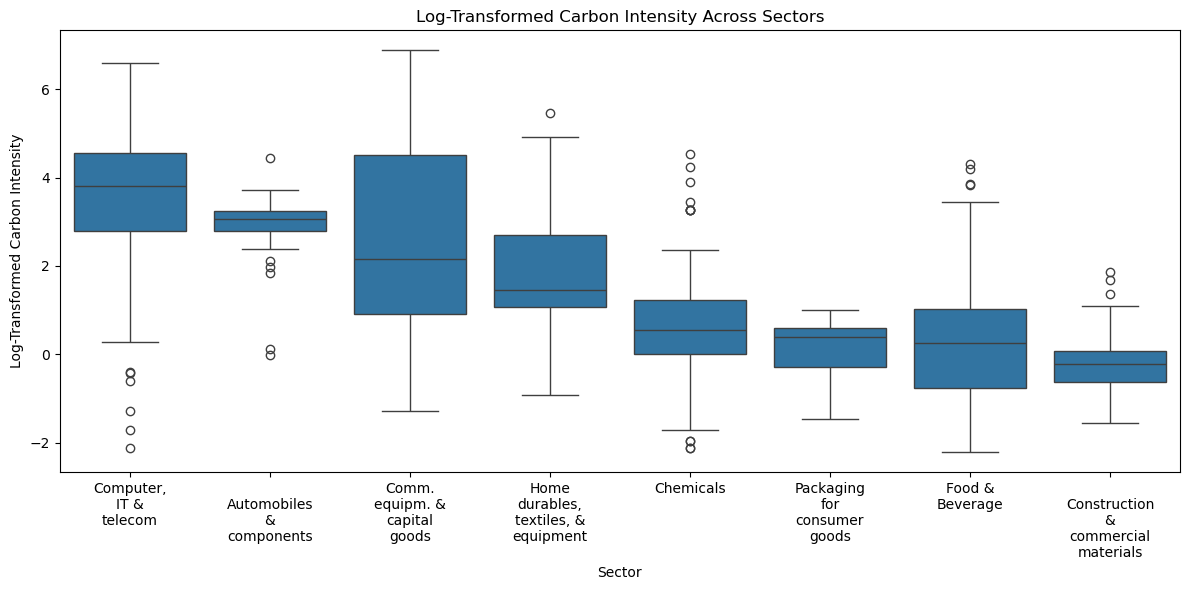

**Fig. 1.** Log-transformed carbon intensity of sectors

There is a significant difference in mean carbon intensity between the 4 analysed sectors ('Food & Beverage', 'Computer, IT & telecom', 'Chemicals', 'Home durables, textiles, & equipment'). A pairwise comparison of the 4 sectors showed that mean carbon intensity of all four selected sectors differs significantly from the other sectors with one exception: "Chemicals" and "Food & Beverage" do not differ (Fig. 2). For this model, the assumptions were met (except for the high variance of "Computer, IT & telecom") and the residuals of the model are approximately normally distributed, which means that we can trust the model results.

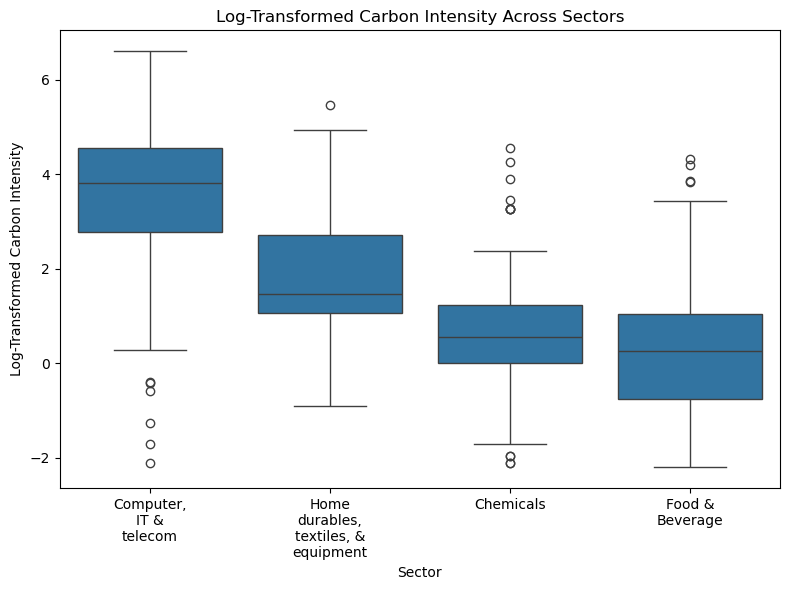

**Fig. 2.** Log-transformed carbon intensity of the 4 analysed sectors

"Computer, IT & telecom" stands out for its high carbon intensity. The reason for the higher carbon intensity of "Computer, IT & telecom" could be the more complex and longer manufacturing process. More insight into the reasons would come out of an analysis of the value chain contributions to carbon intensity.

Limitations and further research recommendations:

The variance in carbon intensity is high for some sectors, so that they overlap with other sectors, for example "Computer, IT & telecom". It was still found to be significantly different. However, one could question the usefulness of this information because now we only know that the MEAN of "Computer, IT & telecom" significantly differs from the other sectors. There could be products that are similar to those in other sectors and on the other hand products that are very different. In order to lower the carbon intensity it would make sense to have a closer look at this.

Furthermore, it would be ideal to test for significant differences in all 8 sectors, but this requires more advanced models. For example, a Generalized Linear Model could help to deal with non-normally distributed data.

Our sector analysis can provide a starting point for deciding which sectors show most room for improvement in terms of lowering carbon intensity, but further research into the reasons behind carbon intensity differences is required to determine intervention points.